In [2]:
import FinanceDataReader as fdr
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.expand_frame_repr', False)

### 가설 검증을 위한 데이터 처리
앞서 만든 return_all (주가 데이터에 지수데이터가 추가된 파일) 을 아래와 같이 로드하고, Missing Data 는 제거합니다. 


In [4]:
return_all = pd.read_pickle('return_all.pkl').dropna()  
return_all.index = [datetime.datetime.strftime(dt, '%Y-%m-%d') for dt in return_all.index]

In [5]:
return_all.head().style.set_table_attributes('style="font-size: 12px"')

,open,high,low,close,volume,change,code,name,kosdaq_return,return,win_market
2021-01-05,2270,2285,2200,2250,410263,-0.004425,060310,3S,1.008326,0.995575,0
2021-01-06,2225,2310,2215,2290,570349,0.017778,060310,3S,0.995567,1.017778,1
2021-01-07,2290,2340,2240,2290,519777,0.000000,060310,3S,1.007612,1.000000,0
2021-01-08,2300,2315,2225,2245,462568,-0.019651,060310,3S,0.998918,0.980349,0
2021-01-11,2230,2275,2130,2175,409057,-0.031180,060310,3S,0.988702,0.968820,0


<br>일주일(5영업일)을 수익율의 관찰 기간으로 하고, 관찰 기간 동안 주가 상승이 있으면 저희가 세운 가설들을 유의미한 가설로 판단하겠습니다. 여기서 주가 상승의 기준은  "종가 매수 일부터 다음 5 영업일 동안 최고 종가 수익율" 하겠습니다. 

첫 번째 종목 060310 에 대하여 처리를 먼저 해 보겠습니다. df['close'] * shift(-1) 은 다음 영업일의 종가 수익율을 참조하고, df['close']*shift(-2) 은 그 다음의 영업일의 종가 수익율을 참조합니다. 따라서 매수 후 2 영업일 후, 종가 수익율은 { df['close'] * shift(-1) } * { df['close'] * shift(-2) } 로 계산됩니다. 이렇게 1 영업일, 2 영업일, 3 영업일, 4 영업일, 5 영업일 후 종가 수익율을 새로운 컬럼에 생성하고, 그 중에서 가장 큰 수익율을 고르면 됩니다. 생성된 컬럼 중 가장 큰 값은 max(axis=1) 로 찾습니다. 참고로 max() 에서는 axis=0 이 Default 라서 axis=1 로 정해주지 않으면 열에서 가장 큰 값을 찾게 됩니다. 이 부분을 유의해 주세요.

In [6]:
s = '060310'
df = return_all[return_all['code']==s].sort_index().copy()

df['close_r1'] = df['close'].shift(-1)/df['close'] # 1 일후 종가 수익률
df['close_r2'] = df['close'].shift(-2)/df['close'] # 2 일후 종가 수익률
df['close_r3'] = df['close'].shift(-3)/df['close'] # 3 일후 종가 수익률
df['close_r4'] = df['close'].shift(-4)/df['close'] # 4 일후 종가 수익률
df['close_r5'] = df['close'].shift(-5)/df['close'] # 5 일후 종가 수익률

''' 위 코드와 같은 결과
df['return_1'] = df['return'].shift(-1)
df['return_2'] = df['return'].shift(-2)*df['return'].shift(-1)
df['return_3'] = df['return'].shift(-3)*df['return'].shift(-2)*df['return'].shift(-1)
df['return_4'] = df['return'].shift(-4)*df['return'].shift(-3)*df['return'].shift(-2)*df['return'].shift(-1)
df['return_5'] = df['return'].shift(-5)*df['return'].shift(-4)*df['return'].shift(-3)*df['return'].shift(-2)*df['return'].shift(-1)
'''

df['target'] = df[['close_r1','close_r2','close_r3','close_r4','close_r5']].max(axis=1) # 주어지 컬럼에서 최대 값을 찾고 'target' 에 저장
df.dropna(subset=['close_r1','close_r2','close_r3','close_r4','close_r5'], inplace=True) # 주어진 컬럼 중에 missing 값이 있으면 행을 제거(dropna)하고, 자신을 덮어 씀(inplace=True).

In [7]:
df.head(10).style.set_table_attributes('style="font-size: 12px"')

,open,high,low,close,volume,change,code,name,kosdaq_return,return,win_market,close_r1,close_r2,close_r3,close_r4,close_r5,target
2021-01-05,2270,2285,2200,2250,410263,-0.004425,060310,3S,1.008326,0.995575,0,1.017778,1.017778,0.997778,0.966667,0.971111,1.017778
2021-01-06,2225,2310,2215,2290,570349,0.017778,060310,3S,0.995567,1.017778,1,1.000000,0.980349,0.949782,0.954148,0.949782,1.000000
2021-01-07,2290,2340,2240,2290,519777,0.000000,060310,3S,1.007612,1.000000,0,0.980349,0.949782,0.954148,0.949782,0.958515,0.980349
2021-01-08,2300,2315,2225,2245,462568,-0.019651,060310,3S,0.998918,0.980349,0,0.968820,0.973274,0.968820,0.977728,0.973274,0.977728
2021-01-11,2230,2275,2130,2175,409057,-0.031180,060310,3S,0.988702,0.968820,0,1.004598,1.000000,1.009195,1.004598,1.002299,1.009195
2021-01-12,2165,2225,2125,2185,244835,0.004598,060310,3S,0.997020,1.004598,1,0.995423,1.004577,1.000000,0.997712,1.013730,1.013730
2021-01-13,2185,2210,2170,2175,127817,-0.004577,060310,3S,1.005556,0.995423,0,1.009195,1.004598,1.002299,1.018391,1.022989,1.022989
2021-01-14,2180,2205,2150,2195,174996,0.009195,060310,3S,1.001185,1.009195,0,0.995444,0.993166,1.009112,1.013667,1.029613,1.029613
2021-01-15,2190,2265,2185,2185,345872,-0.004556,060310,3S,0.983831,0.995444,0,0.997712,1.013730,1.018307,1.034325,1.032037,1.034325
2021-01-18,2185,2220,2150,2180,251311,-0.002288,060310,3S,0.979501,0.997712,0,1.016055,1.020642,1.036697,1.034404,1.052752,1.052752


<br>이제 모든 종목에 대하여 For loop 로 매수 종가로 매도 시 수익율을 최대값을 생성합니다. 'max_close' 의 분포를 보니 평균은 1.033, 최소값 0.326, 최대값 3.703 입니다. 단, max_close 는 가설 검정으로 활용할 지표입니다. 매수 후, 몇 번 째 영업일이 최고 수익율인지 알 수 없기 때문에 기간 중 최고 수익율을 이용합니다.

In [7]:
kosdaq_list = pd.read_pickle('kosdaq_list.pkl')

mdl_data = pd.DataFrame()

for code in kosdaq_list['code']:
    df = return_all[return_all['code']==code].sort_index().copy()

    df['close_r1'] = df['close'].shift(-1)/df['close']
    df['close_r2'] = df['close'].shift(-2)/df['close']
    df['close_r3'] = df['close'].shift(-3)/df['close']
    df['close_r4'] = df['close'].shift(-4)/df['close']
    df['close_r5'] = df['close'].shift(-5)/df['close']

    df['max_close'] = df[['close_r1','close_r2','close_r3','close_r4','close_r5']].max(axis=1) # 주어지 컬럼에서 최대 값을 찾음
    df.dropna(subset=['close_r1','close_r2','close_r3','close_r4','close_r5'], inplace=True) # 주어진 컬럼 중에 missing 값이 있으면 행을 제거(dropna)하고, 자신을 덮어 씀(inplace=True).
    
    mdl_data = pd.concat([mdl_data, df], axis=0)    
    
mdl_data.to_pickle('mdl_data.pkl')

<br> 'max_close' 의 분포를 확인합니다.

In [9]:
mdl_data = pd.read_pickle('mdl_data.pkl')
print(mdl_data['max_close'].describe(percentiles=[0.1, 0.2, 0.5, 0.8, 0.9]))

count   426,517.00
mean          1.03
std           0.07
min           0.33
10%           0.98
20%           0.99
50%           1.02
80%           1.06
90%           1.10
max           3.70
Name: max_close, dtype: float64


### <br> 매도 전략 데이터 프로세싱
모델 개발을 위해서는 매도 전략에 따는 수익을 계산을 할 수 있어야 합니다. 이번 장에서는 기본적인 몇 가지 전략의 수익율을 계산해보겠습니다. 저장해 둔 mdl_data pickle 파일을 읽습니다. mdl_data 는 수익률 결과값이 있는 데이터입니다. 


In [9]:
mdl_data = pd.read_pickle('mdl_data.pkl')

<br> **매도 전략 1 - 모든 종목 종가 매수 후, 5 영업일 기간 6% 익절 매도**     
한가지 전략을 테스트 해 보겠습니다. 모든 종목을 같은 금액으로 매일 종가 매수합니다. 매수 후 5 영업일 동안 수익율이 6% 이상되면 곧바로 익절합니다. 나머지 종목은 5 영업일에 전부 종가 매도하면 수익율은 어떻게 될까요?   

In [10]:
kosdaq_list = pd.read_pickle('kosdaq_list.pkl')

data_all_5 = pd.DataFrame()

ub = 1.06

for code in kosdaq_list['code']:
    
    # 종목별 처리
    data = mdl_data[mdl_data['code']==code].sort_index().copy()
    
    # 고가, 저가, 종가 수익율
    for i in [1, 2, 3, 4, 5]:

        data['high_r' + str(i)] = data['high'].shift(-1*i)/data['close']      
        data['low_r' + str(i)] = data['low'].shift(-1*i)/data['close']   
        data['close_r' + str(i)] = data['close'].shift(-1*i)/data['close']    
        
    data['max_high']  = (data[['high_r1','high_r2','high_r3','high_r4','high_r5']].max(axis=1) > ub).astype(int) # 5 영업일 최고가 중 최고가         
    data['ub_return'] = np.where(data['max_high']==1, ub, data['close_r5']) # 종가 수익률이 6% 이면 매도, 아니면 마지막 5 영업일 수익률
       
    data.dropna(subset=['close_r1','close_r2','close_r3','close_r4','close_r5'], inplace=True)   
    data_all_5 = pd.concat([data, data_all_5], axis=0)

data_all_5.to_pickle('data_all_5.pkl') 


In [12]:
data_all_5.head().style.set_table_attributes('style="font-size: 12px"')

,open,high,low,close,volume,change,code,name,kosdaq_return,return,win_market,close_r1,close_r2,close_r3,close_r4,close_r5,max_close,high_r1,low_r1,high_r2,low_r2,high_r3,low_r3,high_r4,low_r4,high_r5,low_r5,max_high,ub_return
2021-01-05,13000,13050,12750,12900,190192,-0.011494,238490,힘스,1.008326,0.988506,0,1.015504,1.015504,1.003876,1.011628,1.038760,1.038760,1.031008,0.984496,1.034884,1.007752,1.027132,0.992248,1.011628,0.965116,1.081395,1.007752,1,1.060000
2021-01-06,13050,13300,12700,13100,287008,0.015504,238490,힘스,0.995567,1.015504,1,1.000000,0.988550,0.996183,1.022901,1.015267,1.022901,1.019084,0.992366,1.011450,0.977099,0.996183,0.950382,1.064885,0.992366,1.045802,1.003817,1,1.060000
2021-01-07,13200,13350,13000,13100,203149,0.000000,238490,힘스,1.007612,1.000000,0,0.988550,0.996183,1.022901,1.015267,1.007634,1.022901,1.011450,0.977099,0.996183,0.950382,1.064885,0.992366,1.045802,1.003817,1.019084,1.000000,1,1.060000
2021-01-08,13200,13250,12800,12950,209722,-0.011450,238490,힘스,0.998918,0.988550,0,1.007722,1.034749,1.027027,1.019305,1.027027,1.034749,1.007722,0.961390,1.077220,1.003861,1.057915,1.015444,1.030888,1.011583,1.073359,1.019305,1,1.060000
2021-01-11,12850,13050,12450,13050,365602,0.007722,238490,힘스,0.988702,1.007722,1,1.026820,1.019157,1.011494,1.019157,1.038314,1.038314,1.068966,0.996169,1.049808,1.007663,1.022989,1.003831,1.065134,1.011494,1.068966,0.996169,1,1.060000


<br> 수익률의 분포를 확인합니다. 수익이 되는 전략은 아닙니다.

In [13]:
data_all_5 = pd.read_pickle('data_all_5.pkl')
print(data_all_5['ub_return'].describe(percentiles=[0.01, 0.1, 0.5, 0.9, 0.99]))
print(data_all_5.groupby('max_high')['ub_return'].describe())

count   419,432.00
mean          1.00
std           0.06
min           0.29
1%            0.84
10%           0.93
50%           1.00
90%           1.06
99%           1.06
max           1.06
Name: ub_return, dtype: float64
              count  mean  std  min  25%  50%  75%  max
max_high                                               
0        280,145.00  0.97 0.05 0.29 0.95 0.98 1.00 1.06
1        139,287.00  1.06 0.00 1.06 1.06 1.06 1.06 1.06


<br> **매도 전략 2 - 모든 종목을 종가 매수 후, 아래와 같은 순서로 매도**        
1. 익일 고가가 당일 고가 보다 크면 2 영업일 시가 매도   
2.  1 조건 만족하지 않으면 2 영업일 종가 매도  

위와 같은 매도 전략은 수익율이 어떻게 될까요?   

In [13]:
kosdaq_list = pd.read_pickle('kosdaq_list.pkl')

data_all_5 = pd.DataFrame()

def final_r(x):
    
    if   x['high_r0'] < x['high_r1']:  #  (당일 고가/매수 종가) 비율이 (익일 고가/매수 종가) 비율 값이 작으면 2 영업일 시가 매도     
        return x['open_r2']    
    
    else:
        return x['close_r2'] # 매도 안된 종목은 전부 2 영업일 종가 매도         
    
for code in kosdaq_list['code']:    
    
    # 종목별 처리
    data = mdl_data[mdl_data['code']==code].sort_index().copy()
    
    # 최고/최저 수익율
    for i in [0, 1, 2]:

        data['high_r' + str(i)] = data['high'].shift(-1*i)/data['close']        
        data['close_r' + str(i)] = data['close'].shift(-1*i)/data['close']
        data['open_r' + str(i)] = data['open'].shift(-1*i)/data['close']
        
    data['final_return'] = data.apply(final_r, axis=1) # 각 row 에 대하여 final_r 함수를 적용
                                                                                                                                                 
    data.dropna(subset=['close_r0','close_r1', 'close_r2','high_r0', 'high_r1', 'open_r2'], inplace=True)   # 데아터 처리 중 missing 값이 사용된 경우는 제거
    data_all_5 = pd.concat([data, data_all_5], axis=0)

data_all_5.to_pickle('data_all_5.pkl')    

<br> 수익률을 확인합니다.

In [14]:
data_all_5 = pd.read_pickle('data_all_5.pkl')  
data_all_5['final_return'].describe(percentiles=[0.01, 0.1, 0.5, 0.9, 0.99])

count   423,683.00
mean          1.00
std           0.05
min           0.00
1%            0.89
10%           0.96
50%           1.00
90%           1.04
99%           1.15
max           1.69
Name: final_return, dtype: float64

### <br> 매수 전략 데이터 프로세싱
모델 개발을 위해서는 매수 전략에 따라 매수 종목을 결정할 수 있어야 합니다. 이번 장에서는 기본적인 매수 종목을 찾는 데이터처리를 진행해 보겠습니다. 결과 수익률 데이터가 있는
mdl_data pickle 파일을 읽습니다.


In [15]:
mdl_data = pd.read_pickle('mdl_data.pkl')

<br> **매수 전략 1 - 시장 수익율보다 더 좋은 수익율을 보인 종목을 매수**    
시장 수익율보다 더 좋은 수익율을 보인 종목을 알기 위해 4.4.5 절에 'win_market' 이라는 변수를 생성했습니다. 이것을 이용할 것인데요. 더 의미있는 지표를 생성하기 위해서 과거 60일 누적 합을 보겠습니다. 수익율은 max_close(5 영업일 중 최고 종가 수익율) 이용하겠습니다.


In [16]:
kosdaq_list = pd.read_pickle('kosdaq_list.pkl')

data_all_6 = pd.DataFrame()

for code in kosdaq_list['code']:
    
    # 종목별 처리
    data = mdl_data[mdl_data['code']==code].sort_index().copy()
    
    # 과거 60일 win_market 누적 합
    data['win_market_sum'] = data['win_market'].rolling(60).sum() # 과거 60일 누적합
    
    # 고가, 저가, 종가 수익율
    for i in [1,2,3,4,5]:

        data['high_r' + str(i)] = data['high'].shift(-1*i)/data['close']      
        data['low_r' + str(i)] = data['low'].shift(-1*i)/data['close']   
        data['close_r' + str(i)] = data['close'].shift(-1*i)/data['close']    
        
    data['max_close']  = data[['close_r1','close_r2','close_r3','close_r4','close_r5']].max(axis=1) # 5 영업일 종가 수익율 중 최고 값
    data.dropna(subset=['win_market_sum','close_r1','close_r2','close_r3','close_r4','close_r5'], inplace=True) # missing 이 있는 행은 제거   
 
    data_all_6 = pd.concat([data, data_all_6], axis=0)

data_all_6.to_pickle('data_all_6.pkl')    
data_all_6.head().style.set_table_attributes('style="font-size: 12px"')

,open,high,low,close,volume,change,code,name,kosdaq_return,return,win_market,close_r1,close_r2,close_r3,close_r4,close_r5,max_close,win_market_sum,high_r1,low_r1,high_r2,low_r2,high_r3,low_r3,high_r4,low_r4,high_r5,low_r5
2021-04-01,13100,13650,13100,13400,194185,0.022901,238490,힘스,1.010051,1.022901,0,1.007463,1.022388,1.018657,1.041045,1.026119,1.041045,9.000000,1.018657,0.992537,1.029851,1.000000,1.037313,1.007463,1.041045,1.007463,1.048507,1.026119
2021-04-02,13500,13650,13300,13500,136673,0.007463,238490,힘스,1.004463,1.007463,0,1.014815,1.011111,1.033333,1.018519,1.022222,1.033333,9.000000,1.022222,0.992593,1.029630,1.000000,1.033333,1.000000,1.040741,1.018519,1.029630,1.014815
2021-04-05,13600,13800,13400,13700,219062,0.014815,238490,힘스,0.999670,1.014815,1,0.996350,1.018248,1.003650,1.007299,0.992701,1.018248,9.000000,1.014599,0.985401,1.018248,0.985401,1.025547,1.003650,1.014599,1.000000,1.010949,0.989051
2021-04-06,13800,13900,13500,13650,135914,-0.003650,238490,힘스,0.998824,0.996350,0,1.021978,1.007326,1.010989,0.996337,1.003663,1.021978,9.000000,1.021978,0.989011,1.029304,1.007326,1.018315,1.003663,1.014652,0.992674,1.007326,0.996337
2021-04-07,13700,13950,13500,13950,195408,0.021978,238490,힘스,1.004739,1.021978,0,0.985663,0.989247,0.974910,0.982079,1.017921,1.017921,9.000000,1.007168,0.985663,0.996416,0.982079,0.992832,0.971326,0.985663,0.974910,1.021505,0.971326


<br> win_market_sum 에 따른 수익률의 변화를 확인합니다. win_market_sum 이 클수록 수익률이 높아지는 경향이 있다는 것을 확인했습니다.

win_market_sum
(-0.001, 4.0]   1.02
(4.0, 5.0]      1.03
(5.0, 6.0]      1.03
(6.0, 7.0]      1.03
(7.0, 8.0]      1.03
(8.0, 9.0]      1.03
(9.0, 11.0]     1.04
(11.0, 22.0]    1.04
Name: max_close, dtype: float64


<AxesSubplot:xlabel='win_market_sum'>

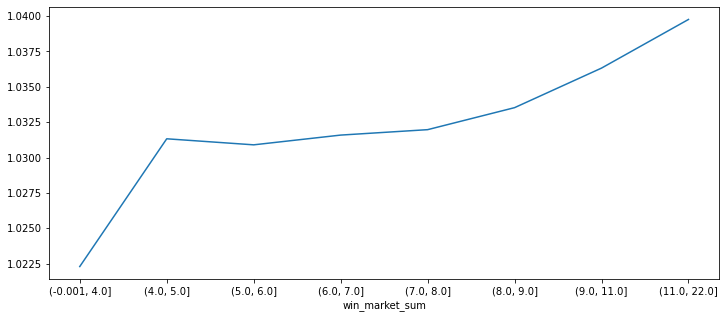

In [17]:
data_all_6 = pd.read_pickle('data_all_6.pkl')    
ranks = pd.qcut(data_all_6['win_market_sum'], q=8)
print(data_all_6.groupby(ranks)['max_close'].mean())
data_all_6.groupby(ranks)['max_close'].mean().plot(figsize=(12,5))

<br> **매수 전략 2 - 섹터 평균 수익율보다 더 높은 수익율을 보인 종목을 매수**    
kosdaq_list 에 있는 종목별 섹터 정보를 이용하겠습니다. 우선, 종목별 최근 60일 평균 수익율을 rolling 함수를 이용하여 으로 계산합니다. for Loop 을 이용하여 종목에 섹터 정보를 추가합니다. 


In [18]:
kosdaq_list = pd.read_pickle('kosdaq_list.pkl')

data_all_6 = pd.DataFrame()

for code, sector in zip(kosdaq_list['code'], kosdaq_list['sector']):
    
    # 종목별 처리
    data = mdl_data[mdl_data['code']==code].sort_index().copy()
    data.dropna(inplace=True)
    
    # 최근 60일 평균 수익율            
    data['return_mean'] = data['return'].rolling(60).mean() # 종목별 최근 60 일 수익율의 평균
    data['sector'] = sector     
  
    data.dropna(subset=['return_mean'], inplace=True)    
    data_all_6 = pd.concat([data, data_all_6], axis=0)

data_all_6.to_pickle('data_all_6.pkl')   

In [19]:
data_all_6 = pd.read_pickle('data_all_6.pkl') 
data_all_6.head().style.set_table_attributes('style="font-size: 12px"')

,open,high,low,close,volume,change,code,name,kosdaq_return,return,win_market,close_r1,close_r2,close_r3,close_r4,close_r5,max_close,return_mean,sector
2021-04-01,13100,13650,13100,13400,194185,0.022901,238490,힘스,1.010051,1.022901,0,1.007463,1.022388,1.018657,1.041045,1.026119,1.041045,1.000755,특수 목적용 기계 제조업
2021-04-02,13500,13650,13300,13500,136673,0.007463,238490,힘스,1.004463,1.007463,0,1.014815,1.011111,1.033333,1.018519,1.022222,1.033333,1.001071,특수 목적용 기계 제조업
2021-04-05,13600,13800,13400,13700,219062,0.014815,238490,힘스,0.999670,1.014815,1,0.996350,1.018248,1.003650,1.007299,0.992701,1.018248,1.001059,특수 목적용 기계 제조업
2021-04-06,13800,13900,13500,13650,135914,-0.003650,238490,힘스,0.998824,0.996350,0,1.021978,1.007326,1.010989,0.996337,1.003663,1.021978,1.000998,특수 목적용 기계 제조업
2021-04-07,13700,13950,13500,13950,195408,0.021978,238490,힘스,1.004739,1.021978,0,0.985663,0.989247,0.974910,0.982079,1.017921,1.017921,1.001556,특수 목적용 기계 제조업


최근 60 일 평균수익율 정보를 섹터 별, 일 별로 요약한 값을 추가합니다. 이때 apply 대신 Transform 함수가 이용되었습니다. apply 는 그룹의 숫자 만큼 행을 리턴하나, transform 은 그룹핑 하기 전의 행 수 를 리턴합니다. 그 값을 'return over sector' 라는 변수에 저장합니다.

In [20]:
data_all_6['sector_return'] = data_all_6.groupby(['sector', data_all_6.index])['return'].transform(lambda x: x.mean())
data_all_6['return over sector'] = (data_all_6['return']/data_all_6['sector_return']) # 섹터의 평균 수익률 대비 종목 수익률의 비율

결과를 보니, 섹터를 이용하여 종목을 선정할 때는 섹터 평균 수익율보다 많이 높거나, 많이 낮는 종목을 선정하는 것이 수익율이 좋게 나왔습니다. 섹터 평균 수익율 대비 종목 수익율은 미래 수익율 예측에 도움이 되는 정보입니다.

                        count  mean   std   min    1%   50%   99%   max
return over sector                                                     
(0.378, 0.974]     34,292.000 1.042 0.086 0.700 0.920 1.022 1.384 2.968
(0.974, 0.984]     34,291.000 1.034 0.067 0.702 0.945 1.018 1.302 2.171
(0.984, 0.99]      34,292.000 1.030 0.061 0.700 0.949 1.016 1.278 2.330
(0.99, 0.994]      34,291.000 1.028 0.059 0.701 0.952 1.014 1.265 2.269
(0.994, 0.999]     34,291.000 1.027 0.058 0.708 0.954 1.013 1.256 2.729
(0.999, 1.002]     34,291.000 1.029 0.066 0.700 0.949 1.013 1.295 3.701
(1.002, 1.007]     34,292.000 1.027 0.059 0.700 0.951 1.012 1.255 3.027
(1.007, 1.013]     34,291.000 1.028 0.062 0.700 0.949 1.013 1.276 3.380
(1.013, 1.026]     34,291.000 1.031 0.067 0.326 0.944 1.014 1.307 2.412
(1.026, 1.399]     34,292.000 1.042 0.103 0.700 0.910 1.019 1.419 3.703


<AxesSubplot:xlabel='return over sector'>

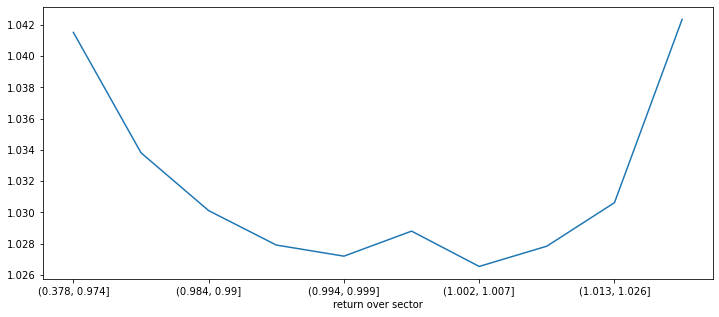

In [21]:
pd.options.display.float_format = '{:,.3f}'.format
ranks = pd.qcut(data_all_6['return over sector'], q=10)
print(data_all_6.groupby(ranks)['max_close'].describe(percentiles=[0.01, 0.99]))
data_all_6.groupby(ranks)['max_close'].mean().plot(figsize=(12,5))

한 섹터에 최소 10 개 이상의 종목이 있어야 섹터의 평균 수익율이 의미가 있을 것 같습니다. 10개 이상의 종목이 있는 섹터만을 매수 대상으로 해서 다시 수익율을 계산해봅니다. 같은 결과를 얻었습니다. 섹터의 평균 수익율보다 아주 낮거나 높은 종목의 수익율의 상승이 높았습니다. 그래프 곡선이 더 부드러워졌습니다.

                        count  mean   std   min    1%   50%   99%   max
return over sector                                                     
(0.688, 0.973]     26,887.000 1.042 0.087 0.700 0.918 1.022 1.388 2.968
(0.973, 0.983]     26,886.000 1.034 0.067 0.702 0.944 1.019 1.299 2.171
(0.983, 0.989]     26,886.000 1.030 0.060 0.704 0.948 1.016 1.267 2.286
(0.989, 0.994]     26,886.000 1.028 0.060 0.700 0.952 1.014 1.269 2.194
(0.994, 0.998]     26,889.000 1.027 0.058 0.819 0.954 1.013 1.255 2.729
(0.998, 1.002]     26,883.000 1.026 0.059 0.700 0.954 1.012 1.257 2.652
(1.002, 1.007]     26,886.000 1.027 0.062 0.700 0.950 1.012 1.257 3.027
(1.007, 1.014]     26,886.000 1.028 0.062 0.700 0.949 1.013 1.285 3.380
(1.014, 1.027]     26,886.000 1.031 0.068 0.700 0.943 1.014 1.315 2.412
(1.027, 1.399]     26,887.000 1.043 0.105 0.700 0.909 1.019 1.423 3.703


<AxesSubplot:xlabel='return over sector'>

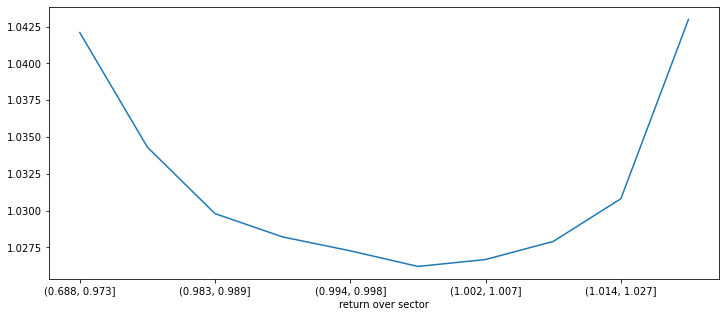

In [22]:
sector_count = data_all_6.groupby('sector')['code'].nunique().sort_values()
data_all_6x = data_all_6[data_all_6['sector'].isin(sector_count[sector_count>=10].index)]
ranks = pd.qcut(data_all_6x['return over sector'], q=10)
print(data_all_6x.groupby(ranks)['max_close'].describe(percentiles=[0.01, 0.99]))
data_all_6x.groupby(ranks)['max_close'].mean().plot(figsize=(12,5))